<a href="https://colab.research.google.com/github/briangasca/Models/blob/xgboost/XGBoost_Model_Ver_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[0]	validation_0-rmse:8.85495	validation_1-rmse:11.43922
[100]	validation_0-rmse:0.89053	validation_1-rmse:19.49573
[0]	validation_0-rmse:212.58604	validation_1-rmse:22.85801
[100]	validation_0-rmse:54.24451	validation_1-rmse:15.45949
[0]	validation_0-rmse:3.05659	validation_1-rmse:10.45262
[100]	validation_0-rmse:0.04715	validation_1-rmse:8.25814
[0]	validation_0-rmse:11.14361	validation_1-rmse:26.98958
[100]	validation_0-rmse:1.32602	validation_1-rmse:54.98256
[0]	validation_0-rmse:49.59226	validation_1-rmse:14.31628
[100]	validation_0-rmse:23.96319	validation_1-rmse:15.97414
[0]	validation_0-rmse:10.74674	validation_1-rmse:10.69700
[100]	validation_0-rmse:0.16706	validation_1-rmse:20.42206
[0]	validation_0-rmse:1.41020	validation_1-rmse:14.02572
[100]	validation_0-rmse:0.18962	validation_1-rmse:13.34161
[0]	validation_0-rmse:20.85769	validation_1-rmse:24.58163
[100]	validation_0-rmse:3.96957	validation_1-rmse:48.79171
[0]	validation_0-rmse:11.11891	validation_1-rmse:13.32627
[100]	v

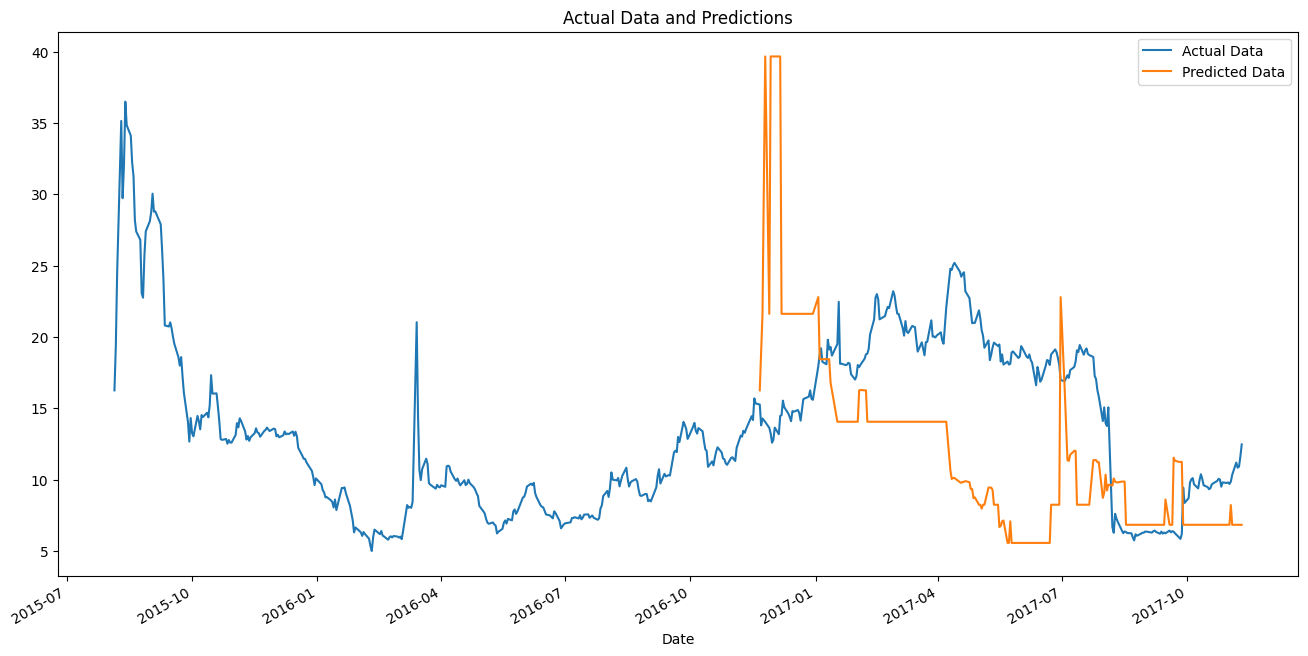

Ensemble MSE: 76.3049415994867
Ensemble RMSE: 8.735269978626116


In [215]:
# HEAVY W.I.P.

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Set up variables
palette = sb.color_palette()

# Initialize datasets
'''
stockDatasets = ["yrd.us.txt", "yten.us.txt", "ytra.us.txt", "yum.us.txt", "yuma.us.txt",
                 "yumc.us.txt", "yume.us.txt", "yy.us.txt", "z.us.txt", "zagg.us.txt",
                 "zais.us.txt", "zayo.us.txt", "zb_a.us.txt", "zb_g.us.txt", "zb_h.us.txt",
                 "zbh.us.txt", "zbio.us.txt", "zbk.us.txt", "zbra.us.txt", "zbzx.us.txt",]
'''
stockDatasets = ["yrd.us.txt", "yten.us.txt", "ytra.us.txt", "yum.us.txt", "yuma.us.txt",
                 "yumc.us.txt", "yume.us.txt", "yy.us.txt", "z.us.txt", "zagg.us.txt",
                 "zais.us.txt", "zayo.us.txt", "zb_a.us.txt"]
# Observation: Adding datasets can change the prediction DRASTICALLY
# Maybe... add datasets until we get lowest error?


dfs = []

zyne_df = pd.read_csv("zyne.us.txt")
zyne_df = zyne_df.set_index("Date")
zyne_df.index = pd.to_datetime(zyne_df.index)

for dataset in stockDatasets:
  df = pd.read_csv(dataset)
  df = df.set_index("Date")
  df.index = pd.to_datetime(df.index)
  dfs.append(df)

# Split data
train_sets = []
test_set = zyne_df.loc[zyne_df.index >= "2016-11-21"]

for df in dfs:
  train_sets.append(df)

# Give train_sets weight based on graph to predict future prices of
#train_predicting_set = df.loc[df.index < "2016-03-07"]
train_predicting_set = zyne_df.loc[zyne_df.index < "2016-11-21"]
weight = 5

# weight mechanic doesn't seem to work if zyne_df is used instead of just df
for i in range(weight):
  train_sets.append(train_predicting_set)

# Create time series from datasets
def create_features(df):
  df = df.copy()
  df["hour"] = df.index.hour
  df["dayofweek"] = df.index.dayofweek
  df["quarter"] = df.index.quarter
  df["month"] = df.index.month
  df["year"] = df.index.year
  df["dayofyear"] = df.index.dayofyear

  return df

for i in range(len(dfs)):
  dfs[i] = create_features(dfs[i])

'''
# For zyne
zyne_df = create_features(zyne_df)
'''

# Convert datasets to time series and prepare data
for i in range(len(train_sets)):
  train_sets[i] = create_features(train_sets[i])

test_set = create_features(test_set)

FEATURES = ["hour", "dayofweek", "quarter", "month", "year", "dayofyear"]
TARGET = "Close"

X_train_samples = []
y_train_samples = []

# Initialize train_sets with X_train samples and y_train samples
for train_set in train_sets:
  X_train = train_set[FEATURES]
  X_train_samples.append(X_train)

  y_train = train_set[TARGET]
  y_train_samples.append(y_train)

X_test_sample = test_set[FEATURES]
y_test_sample = test_set[TARGET]

# Initialize the models
models = []

for i in range(len(train_sets)):
  if i < len(stockDatasets):
    reg_model = xgb.XGBRegressor(n_estimators = 101,
                                early_stopping_rounds = 500,
                                learning_rate = 0.69,
                                max_depth = 2,
                                subsample = 0.999,
                                reg_lambda = 0.901,
                                eta = 0,
                                )
  else:
    reg_model = xgb.XGBRegressor(n_estimators = 101,
                                early_stopping_rounds = 500,
                                learning_rate = 0.69,
                                max_depth = 2,
                                subsample = 0.999,
                                reg_lambda = 0.901,
                                eta = 0,
                                )

  reg_model.fit(X_train_samples[i], y_train_samples[i],
                eval_set = [(X_train_samples[i], y_train_samples[i]), (X_test_sample, y_test_sample)],
                verbose = 100)

  models.append(reg_model)

# Visualize feature importance
fi = pd.DataFrame(data = reg_model.feature_importances_,
                  index = reg_model.feature_names_in_,
                  columns = ["importance"])

# Forecast stock prices
'''
test["prediction"] = reg_model.predict(X_test)
df = df.merge(test[["prediction"]], how = "left", left_index = True, right_index = True)
'''

ensemble_predictions = []

for model in models:
  prediction = model.predict(X_test_sample)
  ensemble_predictions.append(prediction)

final_prediction = np.mean(ensemble_predictions, axis = 0)

## TESTING (all code in this section can be deleted to revert to previous model)##
final_prediction = []

for i in range(len(X_test_sample)):
    closest_prediction_idx = np.argmin([abs(pred[i] - train_predicting_set['Close'][i]) for pred in ensemble_predictions])
    closest_prediction = ensemble_predictions[closest_prediction_idx][i]
    final_prediction.append(closest_prediction)

'''
closest_prediction = ensemble_predictions[0]
min_diff = float("inf")

for i in range(len(ensemble_predictions)):
  for j in range(len(ensemble_predictions[i])):
    if abs(ensemble_predictions[i][j] - y_train_samples[i][j]) < min_diff:
      min_diff = abs(prediction[i] - y_train_samples[i])
      closest_prediction = ensemble_predictions[i]

final_prediction = closest_prediction
'''
########

test_set["prediction"] = final_prediction
zyne_df = zyne_df.merge(test_set[["prediction"]], how = "left", left_index = True, right_index = True)

ax = zyne_df[["Close"]].plot(figsize = (16, 8))
zyne_df["prediction"].plot(ax = ax)
plt.legend(["Actual Data", "Predicted Data"])
ax.set_title("Actual Data and Predictions")
plt.show()

# Evaluate Accuracy
ensemble_mse = mean_squared_error(y_test_sample, final_prediction)
print("Ensemble MSE:", ensemble_mse)
ensemble_rmse = np.sqrt(ensemble_mse)
print("Ensemble RMSE:", ensemble_rmse)

In [ ]:
train_predicting_set['Close'][0]

1.25

In [ ]:
ensemble_predictions[0][0]

16.652817

In [ ]:
test_set.values.tolist()

In [ ]:
y_train_samples[0][0]

Date
2015-12-18     8.7988
2015-12-21     9.0018
2015-12-22     9.2822
2015-12-23     9.1372
2015-12-24     9.1855
               ...   
2017-11-06    42.6400
2017-11-07    41.6300
2017-11-08    41.2700
2017-11-09    42.4900
2017-11-10    42.7100
Name: Close, Length: 479, dtype: float64

In [ ]:
## Optimizing XGBoost ##
# Define the hyperparameter grid
max_depth_options = []
learning_rate_options = []
subsample_options = []
num_parallel_tree_options = []

for i in range(1, 4):
  max_depth_options.append(i)

for i in range(60, 90):
  learning_rate_options.append(i / 100)

for i in range(95, 101):
  subsample_options.append(i / 100)

for i in range(1, 30):
  num_parallel_tree_options.append(i)

param_grid = {
    'n_estimators': [101],
    'learning_rate': [0.69],
    'max_depth': [2],
    'subsample': [0.999],
    'reg_lambda': [0.901],
    'eta': [0],
    'num_parallel_tree': num_parallel_tree_options
}

# Create the GridSearchCV object
grid_search = GridSearchCV(reg_model, param_grid, cv=3, scoring="r2", error_score = "raise")

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'eta': 0, 'learning_rate': 0.69, 'max_depth': 2, 'n_estimators': 101, 'num_parallel_tree': 26, 'reg_lambda': 0.901, 'subsample': 0.999}
Best score:  -4.387692373056005


In [ ]:
test.groupby("date")["error"].mean().sort_values(ascending = False).head(5)

date
2022-01-03    446.590759
2022-01-04    396.400696
2021-11-04    384.496582
2021-11-05    376.676514
2021-11-03    364.760193
Name: error, dtype: float64

In [ ]:
test.groupby("date")["error"].mean().sort_values(ascending = True).head(5)

date
2021-07-12    1.249817
2021-10-15    2.383423
2022-01-28    2.532410
2021-08-18    2.666748
2021-07-30    3.936523
Name: error, dtype: float64